In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
file_path = './vehicles/vehicles.csv'
df = pd.read_csv(file_path)

The attributes that we are working with:

In [4]:
print(df.head())

   cena       marka    model  godina proizvodnje  kilometraža karoserija  \
0  8650       Škoda  Octavia                2016       196000    Karavan   
1  3399     Renault     Clio                2009       196354     Hečbek   
2  3500     Peugeot      207                2009       243892     Hečbek   
3  7000        Audi       A4                2008       211429   Limuzina   
4  1450  Alfa Romeo      147                2008       315000     Hečbek   

   gorivo  kubikaža  snaga motora             menjač broj vrata  \
0   Dizel      1968           150  Manuelni 6 brzina  4/5 vrata   
1  Benzin      1149            58  Manuelni 5 brzina  4/5 vrata   
2   Dizel      1560            90  Manuelni 5 brzina  4/5 vrata   
3  Benzin      1798           160  Manuelni 6 brzina  4/5 vrata   
4   Dizel      1910           120  Manuelni 6 brzina  4/5 vrata   

              klima  
0  Automatska klima  
1        Nema klimu  
2    Manuelna klima  
3    Manuelna klima  
4  Automatska klima  


Basic statistics about the dataset:

In [5]:
print(df.describe())

                cena  godina proizvodnje   kilometraža      kubikaža  \
count   58975.000000        58975.000000  5.897500e+04  5.897500e+04   
mean     9684.405189         2009.507113  2.088346e+05  3.129037e+03   
std     12975.255168            6.593187  1.342026e+05  1.548009e+05   
min         0.000000         1927.000000  0.000000e+00  0.000000e+00   
25%      3200.000000         2006.000000  1.655000e+05  1.496000e+03   
50%      5800.000000         2009.000000  2.040000e+05  1.895000e+03   
75%     11500.000000         2014.000000  2.490000e+05  1.995000e+03   
max    360000.000000         2024.000000  3.960000e+06  2.148215e+07   

       snaga motora  
count  58975.000000  
mean     132.991251  
std       57.911190  
min       18.000000  
25%      101.000000  
50%      120.000000  
75%      150.000000  
max      998.000000  


Missing values in the dataset:

In [6]:
print(df.isnull().sum())

cena                  0
marka                 0
model                 0
godina proizvodnje    0
kilometraža           0
karoserija            2
gorivo                0
kubikaža              0
snaga motora          0
menjač                0
broj vrata            1
klima                 1
dtype: int64


In [7]:
# Invalid price
print(len(df[df['cena'] == 0]))

1


Basic distribution of numerical features:

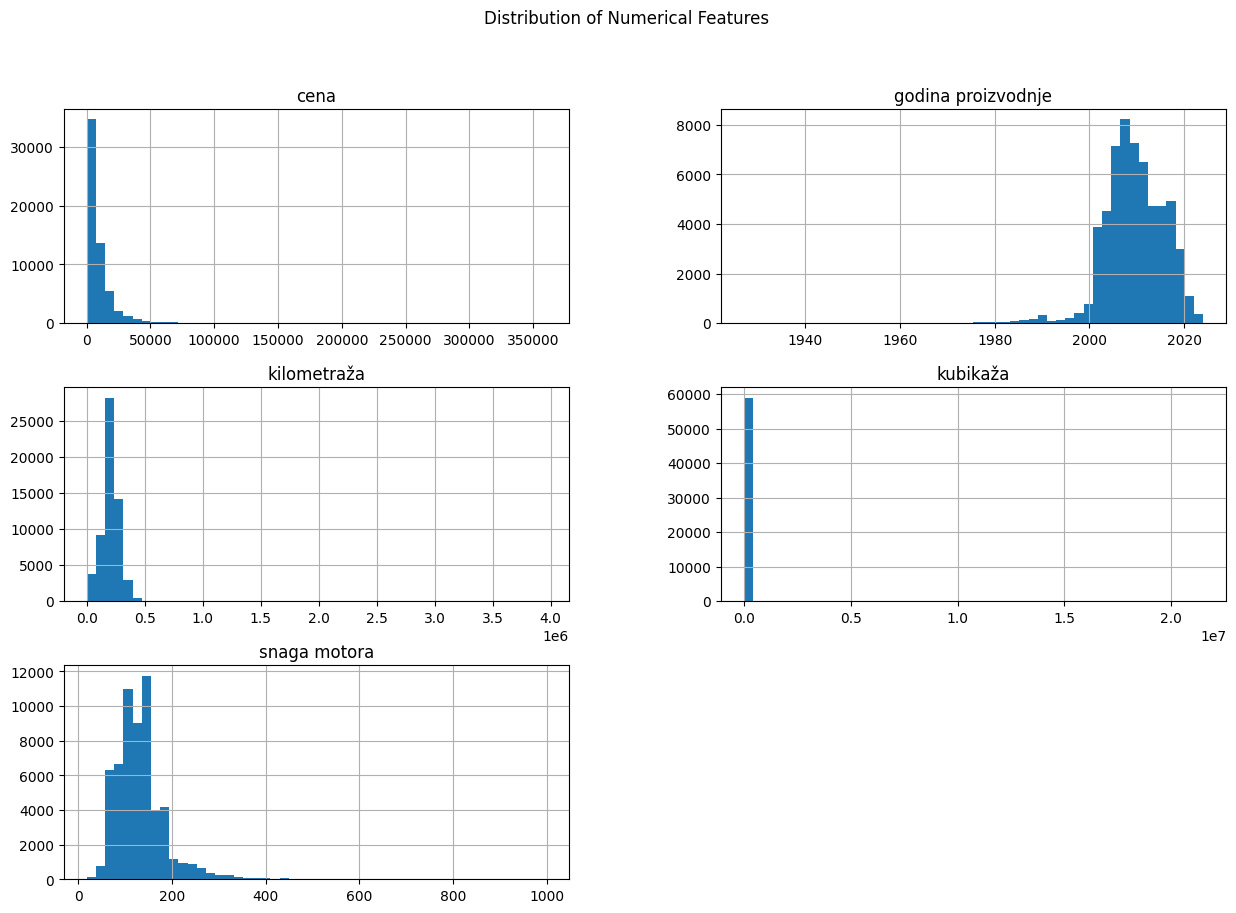

In [8]:
numerical_features = ['cena', 'godina proizvodnje', 'kilometraža', 'kubikaža', 'snaga motora']
df[numerical_features].hist(bins=50, figsize=(15, 10))
plt.suptitle('Distribution of Numerical Features')
plt.show()

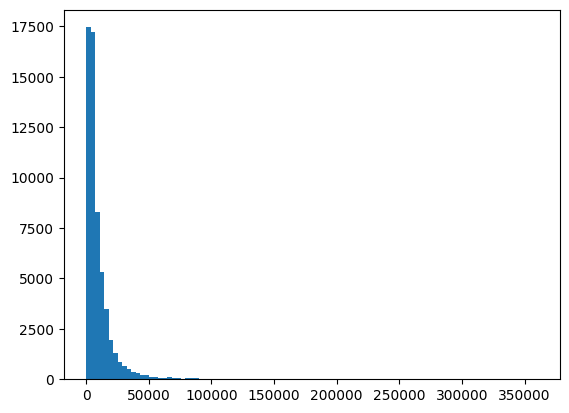

In [9]:
plt.hist(df['cena'], bins=100)
plt.show()

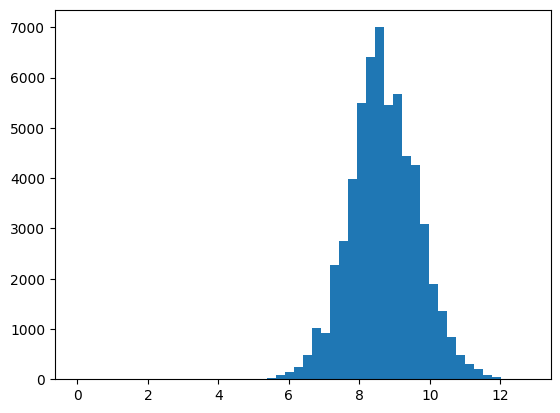

In [10]:
df = df[df['cena'] > 0]
plt.hist(np.log(df['cena']), bins=50)
plt.show()
# df['cena'] = np.log(df['cena'])

Correlation matrix:

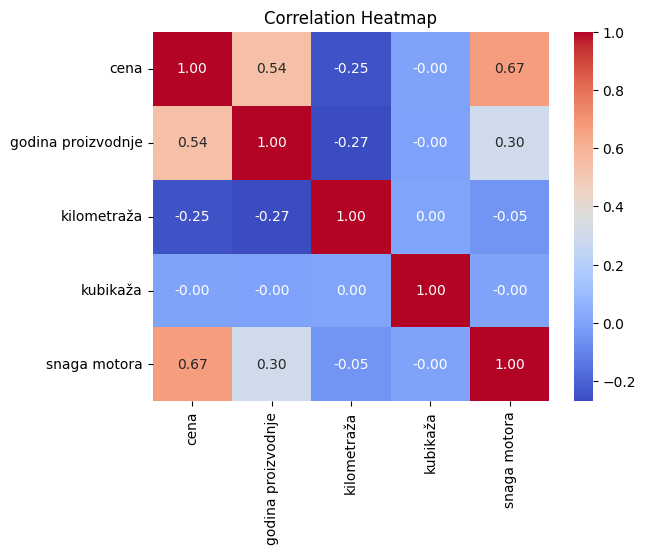

In [11]:
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

> _Engine displacement (kubikaža) has no linear relationship with the price. It might be a good decision to discard it._

Count of vehicles and (mean) price by fuel type:

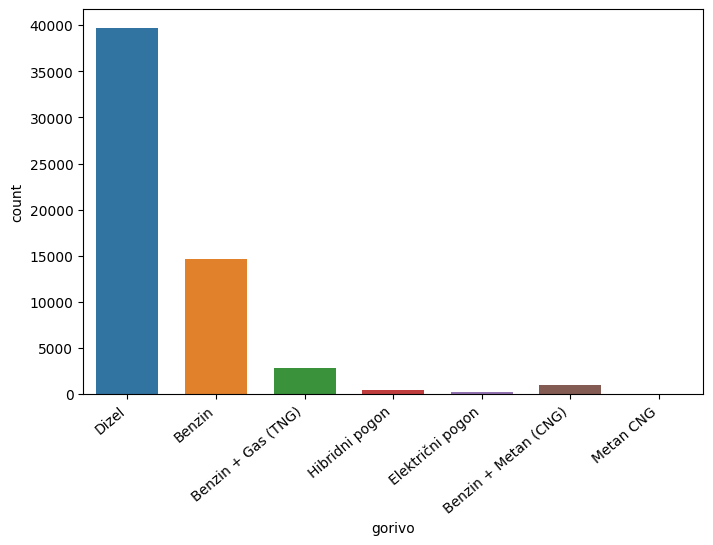

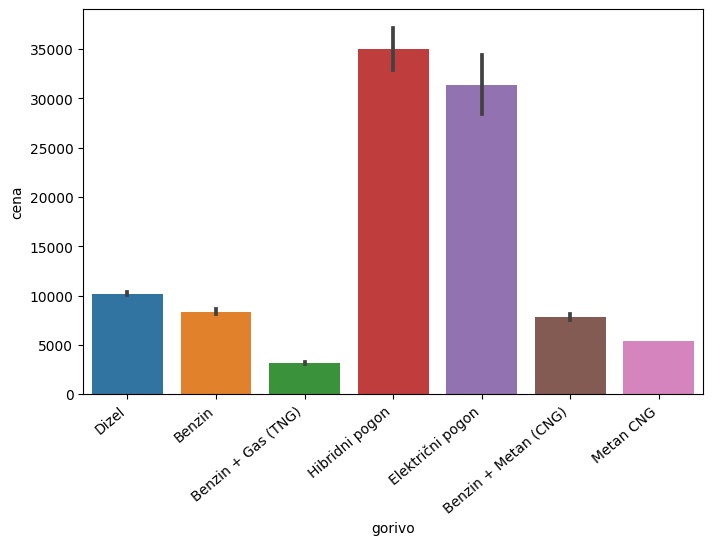

In [12]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='gorivo', data=df, width=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

plt.figure(figsize=(8,5))
ax = sns.barplot(x='gorivo', y='cena', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

> _Diesel and Petrol seem to be taking up almost all values. TNG might be worth considering too, but other fuel types should probably be discarded because of lack of data._

Correlation between price and air conditioning type:

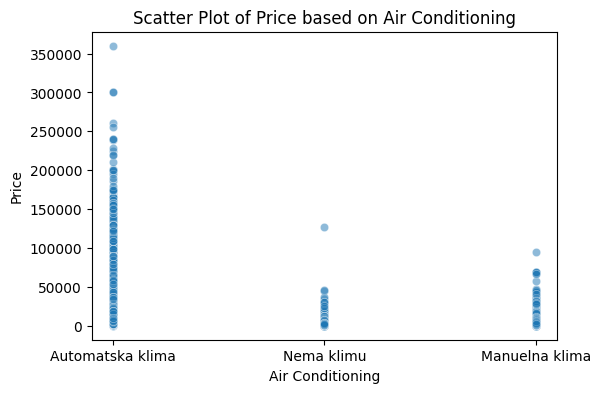

<AxesSubplot: xlabel='klima', ylabel='cena'>

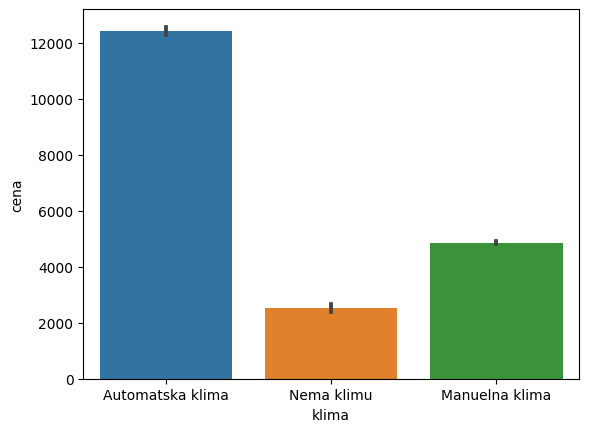

In [13]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='klima', y='cena', data=df, alpha=0.5)
plt.title('Scatter Plot of Price based on Air Conditioning')
plt.xlabel('Air Conditioning')
plt.ylabel('Price')
plt.show()

sns.barplot(x='klima', y='cena', data=df)

> _Seems like there isn't a clear distinction when it comes to the correlation regarding cheaper cars. The only thing we can say for sure is that very expensive vehicles definitely have automatic AC._

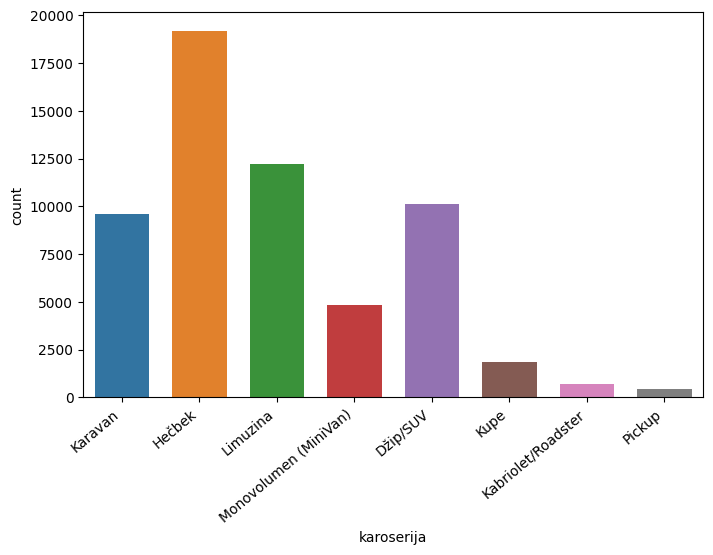

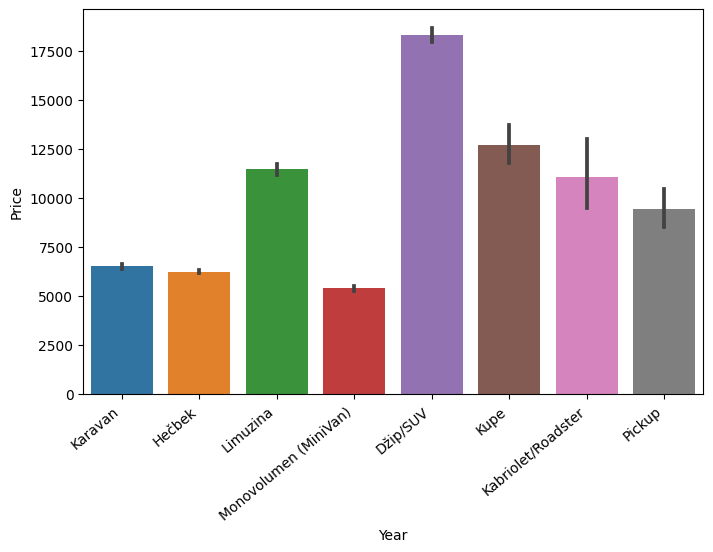

<Figure size 800x500 with 0 Axes>

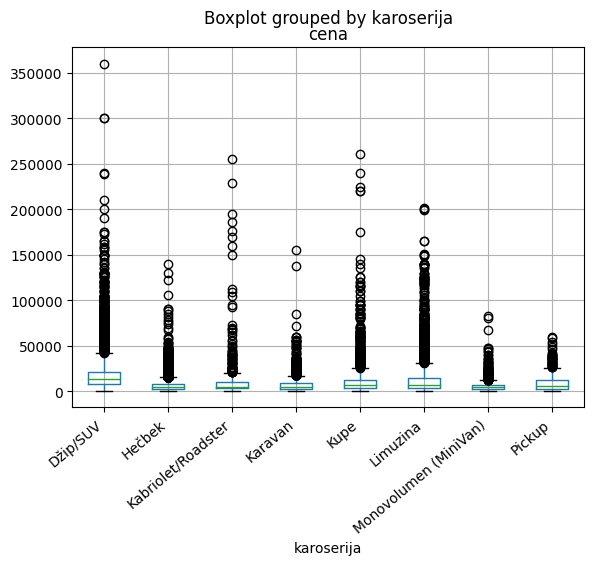

In [14]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x='karoserija', data=df, width=0.7)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

plt.figure(figsize=(8,5))
ax = sns.barplot(x='karoserija', y='cena', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

plt.figure(figsize=(8,5))
ax = df.boxplot(column='cena', by='karoserija')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

<Figure size 1200x600 with 0 Axes>

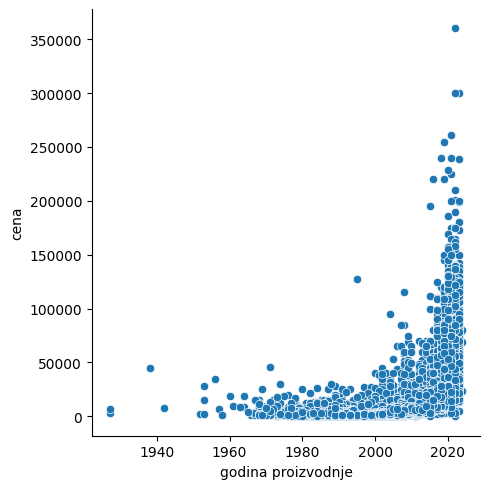

In [15]:
plt.figure(figsize=(12,6))
sns.relplot(x='godina proizvodnje', y='cena', data=df)
plt.show()

<Figure size 1200x600 with 0 Axes>

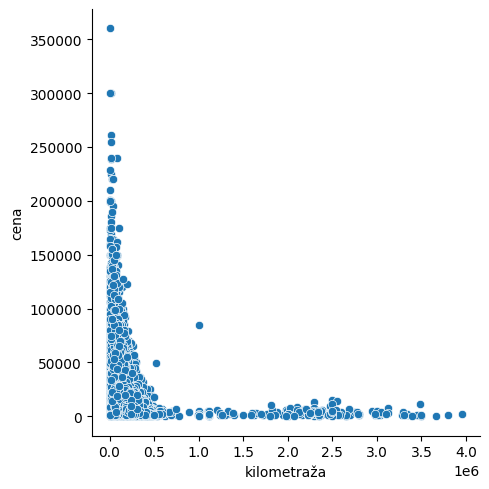

In [16]:
plt.figure(figsize=(12,6))
sns.relplot(x='kilometraža', y='cena', data=df)
plt.show()